In [57]:
# -*- coding: UTF-8 -*-
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str, zip
import re
import os
from glob import glob
from copy import deepcopy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.svm import LinearSVC
from gensim.models.word2vec import Word2Vec
from nlputils.dict_utils import invert_dict2
from nlputils.features import preprocess_text
from nlputils.simmat import dist2kernel
from nlputils.embedding import proj2d
from nlputils.visualize import basic_viz, get_colors
from word_emb_sim import compute_w2v_K, transform_word2vec_featmat

py.init_notebook_mode()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data and bootstrap emotion labels

In [2]:
# load posts with partially annotated categories
df = pd.read_csv("data/posts_categories.tsv", sep="\t")
posts = {}
posts_pp = {}
post_categories = {}
post_subcategories = {}
post_likes = {}
post_love = {}
post_haha = {}
post_sad = {}
post_wow = {}
post_angry = {}
# read in all posts and (if available) category
for i in range(len(df)):
    if not pd.isna(df.iloc[i]["link"]) and not pd.isna(df.iloc[i]["post_message"]):
        posts[df.iloc[i]["post_id"]] = df.iloc[i]["post_message"]
        # count reactions
        post_likes[df.iloc[i]["post_id"]] = df.iloc[i]["likes_count_fb"]
        post_love[df.iloc[i]["post_id"]] = df.iloc[i]["rea_LOVE"]
        post_haha[df.iloc[i]["post_id"]] = df.iloc[i]["rea_HAHA"]
        post_sad[df.iloc[i]["post_id"]] = df.iloc[i]["rea_SAD"]
        post_wow[df.iloc[i]["post_id"]] = df.iloc[i]["rea_WOW"]
        post_angry[df.iloc[i]["post_id"]] = df.iloc[i]["rea_ANGRY"]
        # get category (all labeled) and possibly subcategory (some have more than 1!!)
        post_categories[df.iloc[i]["post_id"]] = df.iloc[i]["category_new"]
        if not pd.isna(df.iloc[i]["subcategory"]):
            post_subcategories[df.iloc[i]["post_id"]] = df.iloc[i]["subcategory"].split(", ")
        # for articles we can also extract the headline from the url
        if not df.iloc[i]["link_domain"] == "facebook.com":
            link = df.iloc[i]["link"]
            if df.iloc[i]["link_domain"] == "m.exactag.com":
                try:
                    link = link.split("bild-plus%2F")[1].replace("%2F", " ")
                except:
                    link = link.split("bild.de%2F")[1].replace("%2F", " ")
            else:
                link = link.split(df.iloc[i]["link_domain"])[1]
            posts[df.iloc[i]["post_id"]] += " " + " ".join(re.findall("[A-Za-z]+", re.sub("[0-9]+.bild.html", "", link)))
        # preprocess text and manually add emojis again
        pp = preprocess_text(posts[df.iloc[i]["post_id"]])
        char_counts = Counter(list(df.iloc[i]["post_message"]))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp += " " + " ".join(char_counts[c]*[c])
        posts_pp[df.iloc[i]["post_id"]] = pp

In [3]:
# read in sentiment words
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Negative-21042012.tsv", sep="\t", header=None)
sent_neg = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Positive-21042012.tsv", sep="\t", header=None)
sent_pos = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Neutral-21042012.tsv", sep="\t", header=None)
sent_neu = set(preprocess_text(t) for t in df[0])
# read in emotion words and assign to 4 emotions
# https://www.microsoft.com/developerblog/2015/11/29/emotion-detection-and-recognition-from-text-using-deep-learning/
df = pd.read_csv("data/emotion_words/Wut.txt", sep="\t", header=None)
emo_Wut = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Angst.txt", sep="\t", header=None)
emo_Angst = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Freude.txt", sep="\t", header=None)
emo_Freude = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Trauer.txt", sep="\t", header=None)
emo_Trauer = set(preprocess_text(t) for t in df[0])
# define emotion emojis
# https://www.insight-centre.org/sites/default/files/publications/ianwood-emotionworkshop.pdf
emojis_Freude = set("😀😃😄😁😆😅😂🤣☺😊😇🙂🙃😉😌😍😘😗😙😚😋😛😜🤪🤩😎😺😸😹😻😽🙌👏👍✌👌🎉❤💕💞💓💗💖♥")
emojis_Trauer = set("😞😔😟😕🙁☹😣😖😫😩😢😭😥😶😐😧😦😪😿👎💔")
emojis_Wut = set("😒😑😤😠😡🤬😾🖕💩👿😝")
emojis_Angst = set("😱😳😨😰😵😧😮😲🙀")
emotions_list = ["Freude", "Trauer", "Angst", "Wut", "-"]

def label_word_sent(w):
    sent_label = 0.
    if w in sent_neg:
        sent_label = -1.
    elif w in sent_pos:
        sent_label = +1.
    return sent_label

def label_word_emo(w):
    emo_label = "-"
    if w in emo_Wut:
        emo_label = "Wut"
    elif w in emo_Angst:
        emo_label = "Angst"
    elif w in emo_Freude:
        emo_label = "Freude"
    elif w in emo_Trauer:
        emo_label = "Trauer"
    return emo_label

In [4]:
# read in comments for all posts
comments = {i: {} for i in posts}
comments_pp = {i: {} for i in posts}
number_of_words = {i: {} for i in posts}
sent_scores = {i: {} for i in posts}
emo_Wut_scores = {i: {} for i in posts}
emo_Angst_scores = {i: {} for i in posts}
emo_Trauer_scores = {i: {} for i in posts}
emo_Freude_scores = {i: {} for i in posts}
emo_main_label = {i: {} for i in posts}
df = pd.read_csv("data/all_comments.csv", sep="\t")
for i in range(len(df)):
    post_id, comment_message = df.iloc[i]["post_id"], df.iloc[i]["comment_message"]
    comment_id = post_id + " %i" % i
    if post_id in comments and not pd.isna(comment_message) and preprocess_text(comment_message):
        comments[post_id][comment_id] = comment_message
        pp_l = preprocess_text(comment_message)
        # based on the preprocessed words, get sentiment and word based emotion scores
        sent_scores[post_id][comment_id] = np.mean([label_word_sent(word) for word in pp_l.split()])
        emotions = Counter([label_word_emo(word) for word in pp_l.split()])
        # add scores based on emojis (from non-preprocessed text!)
        char_counts = Counter(list(comment_message))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp_l += " " + " ".join(char_counts[c]*[c])
                if c in emojis_Wut:
                    emotions["Wut"] += char_counts[c]
                elif c in emojis_Angst:
                    emotions["Angst"] += char_counts[c]
                elif c in emojis_Freude:
                    emotions["Freude"] += char_counts[c]
                elif c in emojis_Trauer:
                    emotions["Trauer"] += char_counts[c]
        comments_pp[post_id][comment_id] = pp_l
        n_tokens = len(pp_l.split())
        number_of_words[post_id][comment_id] = n_tokens
        emotions["-"] = 0
        emo_main_label[post_id][comment_id] = max(emotions, key=emotions.get)
        emo_Wut_scores[post_id][comment_id] = emotions["Wut"]/n_tokens
        emo_Angst_scores[post_id][comment_id] = emotions["Angst"]/n_tokens
        emo_Trauer_scores[post_id][comment_id] = emotions["Trauer"]/n_tokens
        emo_Freude_scores[post_id][comment_id] = emotions["Freude"]/n_tokens

## Refine labels

### Train word2vec embeddings

In [5]:
# get all comments and posts as lists of lists
sentences = []
for post_id in posts_pp:
    posts_pp[post_id] = posts_pp[post_id].split()
    sentences.append(posts_pp[post_id])
    for i in comments_pp[post_id]:
        comments_pp[post_id][i] = comments_pp[post_id][i].split()
        sentences.append(comments_pp[post_id][i])

In [6]:
# train word2vec model
model = Word2Vec(sentences, size=100, window=10, min_count=3, workers=4)
word_vectors = model.wv
del model
word_vectors.init_sims(replace=True)

In [7]:
word_vectors.most_similar(positive=['🙈'])

[('🙊', 0.79115891456604),
 ('😅', 0.76604163646698),
 ('🙉', 0.6840646266937256),
 ('🙄', 0.6587830781936646),
 ('😜', 0.5679758787155151),
 ('😂', 0.5534166097640991),
 ('😬', 0.5494899153709412),
 ('😳', 0.533552885055542),
 ('😄', 0.5203614234924316),
 ('\U0001f92a', 0.5002732276916504)]

In [8]:
word_vectors.most_similar(positive=['merkel'])

[('merkels', 0.6838992834091187),
 ('nahles', 0.6267062425613403),
 ('spd', 0.6074931025505066),
 ('mutti', 0.5607163310050964),
 ('leyen', 0.5345386862754822),
 ('politik', 0.5304017066955566),
 ('regierung', 0.5284755229949951),
 ('kanzlerin', 0.5189735889434814),
 ('ferkel', 0.5028231143951416),
 ('klum', 0.49994388222694397)]

### Get missing post categories

In [9]:
# we actually have all labels for the posts now, don't need to do this
if True:
    train_ids = sorted(post_categories.keys())
    #test_ids = sorted([p for p in posts.keys() if not p in train_ids])
    posts_train = transform_word2vec_featmat(posts_pp, train_ids, word_vectors, avg='simple avg')
    #posts_test = transform_word2vec_featmat(posts_pp, test_ids, word_vectors, avg='simple avg')
    y = np.array([post_categories[p] for p in train_ids])
    clf = LinearSVC(class_weight='balanced')
    clf.fit(posts_train, y)
    print(np.mean(y==clf.predict(posts_train)))
    #y_pred_test = clf.predict(posts_test)
    #for i, pid in enumerate(test_ids):
    #    post_categories[pid] = y_pred_test[i]
    del posts_train#, posts_test

0.6346967559943583


In [10]:
# visualize posts
ids = sorted(post_categories.keys())
textdict = {did: "<br>".join([" ".join(posts[did].split()[i:min(i+5, len(posts[did].split()))]) for i in range(0, len(posts[did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, posts_pp, word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

performing tSNE: 1418 datapoints
Iteration 25: error is 4.18936
Iteration 50: error is 4.24580
Iteration 75: error is 4.35739
Iteration 100: error is 4.38615
Iteration 125: error is 2.52101
Iteration 150: error is 2.17942
Iteration 175: error is 2.01221
Iteration 200: error is 1.97707
Iteration 225: error is 1.95309
Iteration 250: error is 1.92295
Iteration 275: error is 1.89426
Iteration 300: error is 1.87734
Iteration 325: error is 1.86590
Iteration 350: error is 1.85774
Iteration 375: error is 1.85243
Iteration 400: error is 1.84840
Iteration 425: error is 1.84531
Iteration 450: error is 1.84291
Iteration 475: error is 1.84074
Iteration 500: error is 1.83770
Iteration 525: error is 1.83613
Iteration 550: error is 1.83518
Iteration 575: error is 1.83427
Iteration 600: error is 1.83343
Iteration 625: error is 1.83264
Iteration 650: error is 1.83205
Iteration 675: error is 1.83145
Iteration 700: error is 1.83080
Iteration 725: error is 1.83026
Iteration 750: error is 1.82945
Iteration 

In [11]:
def create_fig_cats(doc_ids, doccats, x, y, textdict, title):
    categories = sorted(set(doccats.values()))
    colorlist = get_colors(len(categories))
    colordict = {cat: "rgb(%i,%i,%i)" % (255 * colorlist[i][0], 255 * colorlist[i][1], 255 * colorlist[i][2]) for i, cat in enumerate(categories)}
    data = []
    for j, cat in enumerate(categories):
        # get docids that belong to the current category
        didx_temp = [i for i, did in enumerate(doc_ids) if cat == doccats[did]]
        trace = go.Scatter(
                    x=x[didx_temp],
                    y=y[didx_temp],
                    mode='markers',
                    marker=dict(
                        size=10,
                        opacity=0.6,
                        color=colordict[cat]
                    ),
                    text=[textdict[did] for did in doc_ids if cat == doccats[did]],
                    hoverinfo='text',
                    name=cat
                )
        data.append(trace)
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False),
                showlegend=True
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

def create_fig_scores(doc_ids, docscores, x, y, textdict, title):
    trace = go.Scatter(
                    x = x,
                    y = y,
                    mode = 'markers',
                    marker=dict(
                        size=10,
                        opacity=0.8,
                        color = [docscores[i] for i in ids],
                        showscale=True
                    ),
                    text = [textdict[i] for i in ids],
                    hoverinfo='text'
            )
    data = [trace]
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False)
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

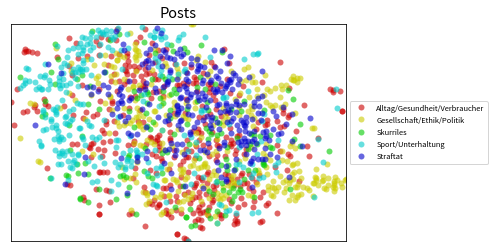

In [12]:
# basic non-interactive plot
categories = sorted(set(post_categories.values()))
basic_viz(ids, post_categories, x, y, dict(zip(categories, categories)), "Posts")

In [13]:
# interactive plots
fig_cats = create_fig_cats(ids, post_categories, x, y, textdict, "Posts")
py.iplot(fig_cats)

### Relabel comments with emotions

In [14]:
post_ids = sorted(posts.keys())
print("getting comment vectors")
comment_vectors = [transform_word2vec_featmat(comments_pp[p], sorted(comments_pp[p]), word_vectors, avg='simple avg') for p in post_ids]
print("getting comment labels")
y = []
for p in post_ids:
    y.extend([emo_main_label[p][c] for c in sorted(emo_main_label[p])])
y = np.array(y)
print("training clf")
clf = LinearSVC(class_weight='balanced')
clf.fit(np.vstack(comment_vectors), y)
print(np.mean(y==clf.predict(np.vstack(comment_vectors))))
print("generating new labels")
emo_main_label_pred = deepcopy(emo_main_label)
for i, p in enumerate(post_ids):
    y_pred_test = clf.predict(comment_vectors[i])   
    for j, c in enumerate(sorted(emo_main_label[p])):
        emo_main_label_pred[p][c] = y_pred_test[j]
del comment_vectors

getting comment vectors
getting comment labels
training clf
0.706916242824592
generating new labels


In [15]:
# visualize
pid = post_ids[5]  # change number here to analyze the comments of a different post
print(posts[pid])
print(post_categories[pid])
ids = np.random.permutation(list(comments_pp[pid]))[:3000]
textdict = {did: "<br>".join([" ".join(comments[pid][did].split()[i:min(i+5, len(comments[pid][did].split()))]) for i in range(0, len(comments[pid][did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, comments_pp[pid], word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

Mit verschränkten Armen sitzt Dimitri K. im Gerichtssaal. Was er von der Polizei hält  trägt er in seinem Gesicht provokant als Tattoo zur Schau: „Fuck Cops“. regional hamburg g gipfel der hass steht diesem g chaoten ins gesicht geschrieben
Straftat
performing tSNE: 419 datapoints
Iteration 25: error is 4.30564
Iteration 50: error is 4.23785
Iteration 75: error is 3.91236
Iteration 100: error is 4.21823
Iteration 125: error is 2.29548
Iteration 150: error is 1.64470
Iteration 175: error is 1.28924
Iteration 200: error is 1.21593
Iteration 225: error is 1.17004
Iteration 250: error is 1.13854
Iteration 275: error is 1.11850
Iteration 300: error is 1.10034
Iteration 325: error is 1.09295
Iteration 350: error is 1.08706
Iteration 375: error is 1.08267
Iteration 400: error is 1.07927
Iteration 425: error is 1.07486
Iteration 450: error is 1.06645
Iteration 475: error is 1.06283
Iteration 500: error is 1.06042
Iteration 525: error is 1.05644
Iteration 550: error is 1.05561
Iteration 575: er

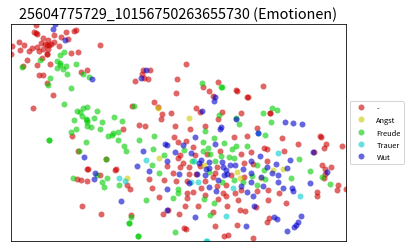

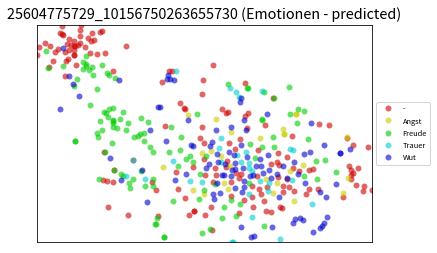

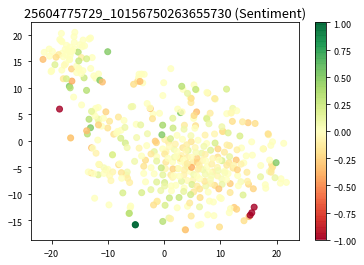

In [16]:
# basic non-interactive plot with emotions and sentiment coloring
basic_viz(ids, emo_main_label[pid], x, y, dict(zip(emotions_list, emotions_list)), pid + " (Emotionen)")
basic_viz(ids, emo_main_label_pred[pid], x, y, dict(zip(emotions_list, emotions_list)), pid + " (Emotionen - predicted)")
plt.figure()
plt.scatter(x, y, c=[sent_scores[pid][i] for i in ids], alpha=0.8, cmap="RdYlGn")
plt.colorbar()
plt.title(pid + " (Sentiment)");

In [17]:
# interactive plots
fig_emo = create_fig_cats(ids, emo_main_label[pid], x, y, textdict, pid + " (Emotionen)")
fig_emo_pred = create_fig_cats(ids, emo_main_label_pred[pid], x, y, textdict, pid + " (Emotionen - predicted)")
fig_sent = create_fig_scores(ids, sent_scores[pid], x, y, textdict, pid + " (Sentiment)")

py.iplot(fig_emo)
py.iplot(fig_emo_pred)
py.iplot(fig_sent)

### Compute basic stats

#### Number of words in comments

         Gesellschaft/Ethik/Politik: 21.39 +/- 26.63   13.0
                           Straftat: 16.54 +/- 21.15   10.0
                 Sport/Unterhaltung: 11.92 +/- 15.25    7.0
                          Skurriles:  7.54 +/-  9.68    5.0
      Alltag/Gesundheit/Verbraucher:  8.32 +/- 12.66    5.0


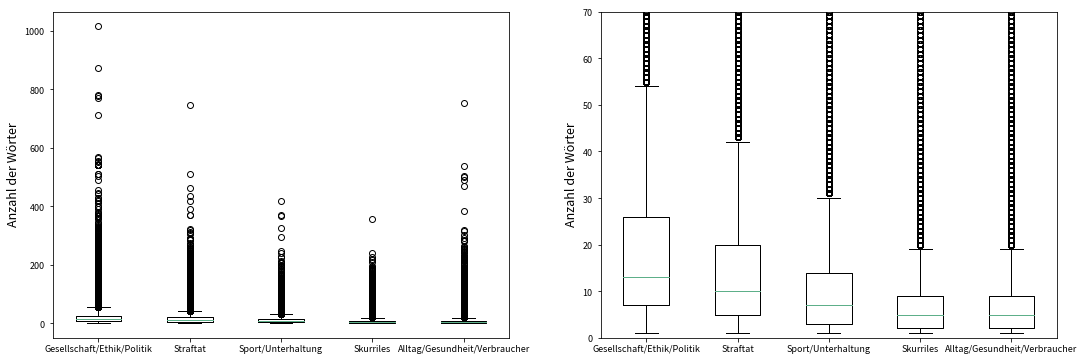

In [45]:
# number of words in comments based on post category
n_words = []
categories = ['Gesellschaft/Ethik/Politik', 'Straftat', 'Sport/Unterhaltung', 'Skurriles', 'Alltag/Gesundheit/Verbraucher']
for post_cat in categories:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if post_categories[pid] == post_cat])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=categories)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.subplot(122)
plt.boxplot(n_words, labels=categories)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.ylim([0,70]);
plt.savefig("nwords_categories.png", dpi=300, bbox_inches="tight")
for i, c in enumerate(categories):
    print("%35s: %5.2f +/- %5.2f   %4.1f" % (c, np.mean(n_words[i]), np.std(n_words[i]), np.median(n_words[i])))

                             Merkel: 23.02 +/- 30.80   14.0
                              Trump: 19.14 +/- 20.51   13.0
                          Schicksal: 16.41 +/- 21.75    9.0
                           Fahndung: 16.32 +/- 20.31   10.0
                              Tiere: 11.58 +/- 16.69    7.0
                            Fußball: 11.47 +/- 15.77    7.0
                                Sex: 11.39 +/- 14.96    7.0
                             Wetter:  7.76 +/-  9.30    5.0
                              Liebe:  5.18 +/-  4.65    4.0


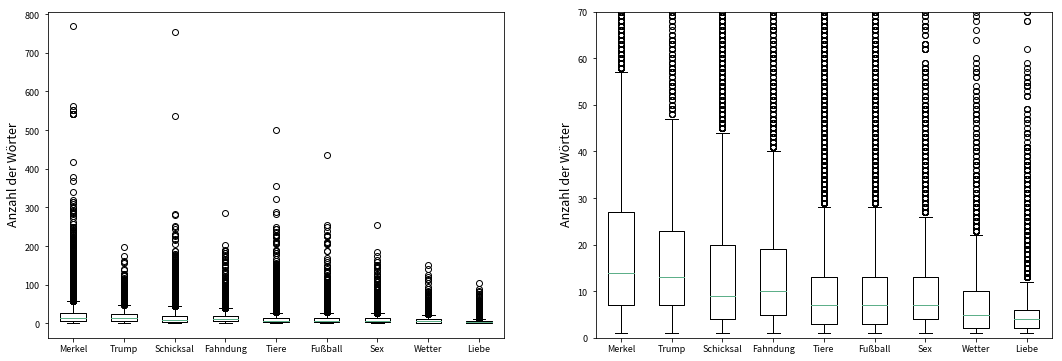

In [46]:
# number of words in comments based on post subcategory
n_words = []
subcategories = ['Merkel', 'Trump', 'Schicksal', 'Fahndung', 'Tiere', 'Fußball', 'Sex', 'Wetter', 'Liebe']
for post_cat in subcategories:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if pid in post_subcategories and post_cat in post_subcategories[pid]])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=subcategories)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.subplot(122)
plt.boxplot(n_words, labels=subcategories)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.ylim([0,70]);
plt.savefig("nwords_subcategories.png", dpi=300, bbox_inches="tight")
for i, c in enumerate(subcategories):
    print("%35s: %5.2f +/- %5.2f   %4.1f" % (c, np.mean(n_words[i]), np.std(n_words[i]), np.median(n_words[i])))

                                Wut: 25.93 +/- 29.83   17.0
                             Trauer: 23.25 +/- 26.52   15.0
                              Angst: 23.21 +/- 28.35   14.0
                             Freude: 14.19 +/- 20.31    8.0
                                  -:  8.36 +/- 10.68    5.0


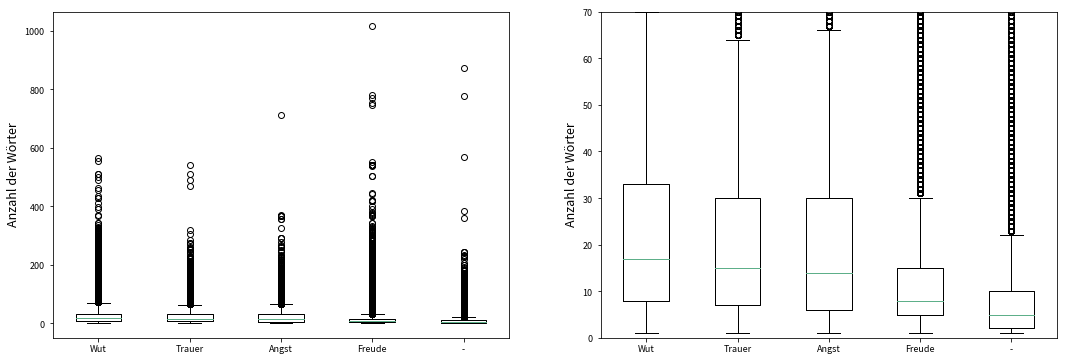

In [50]:
# number of words in comments based on comment emotion (from word lists)
n_words = []
emotions = ["Wut", "Trauer", "Angst", "Freude", "-"]
for emo in emotions:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if emo_main_label[pid][i] == emo])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=emotions)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.subplot(122)
plt.boxplot(n_words, labels=emotions)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.ylim([0,75]);
plt.savefig("nwords_emotions.png", dpi=300, bbox_inches="tight")
for i, c in enumerate(emotions):
    print("%35s: %5.2f +/- %5.2f   %4.1f" % (c, np.mean(n_words[i]), np.std(n_words[i]), np.median(n_words[i])))

                                Wut: 24.35 +/- 27.13   16.0
                             Trauer: 23.76 +/- 27.89   15.0
                              Angst: 22.64 +/- 29.86   14.0
                             Freude: 10.02 +/- 10.37    7.0
                                  -:  8.96 +/- 15.26    4.0


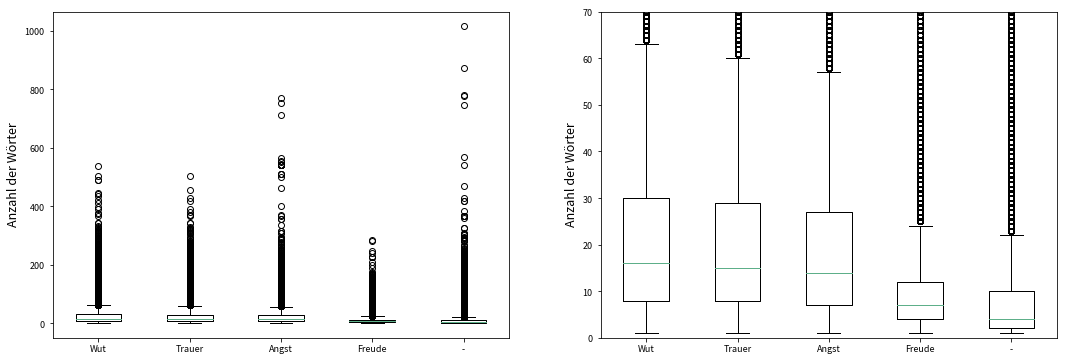

In [51]:
# number of words in comments based on comment emotion (as predicted with word vectors)
n_words = []
for emo in emotions:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if emo_main_label_pred[pid][i] == emo])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=emotions)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.subplot(122)
plt.boxplot(n_words, labels=emotions)
plt.ylabel("Anzahl der Wörter", fontsize=14)
plt.ylim([0,70]);
plt.savefig("nwords_emotions_pred.png", dpi=300, bbox_inches="tight")
for i, c in enumerate(emotions):
    print("%35s: %5.2f +/- %5.2f   %4.1f" % (c, np.mean(n_words[i]), np.std(n_words[i]), np.median(n_words[i])))

#### compare reactions and emotions of posts

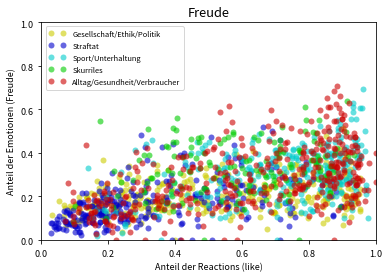

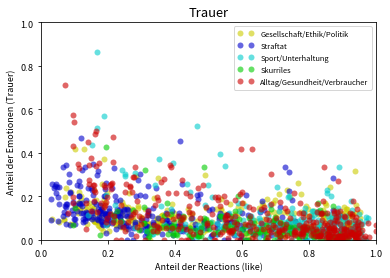

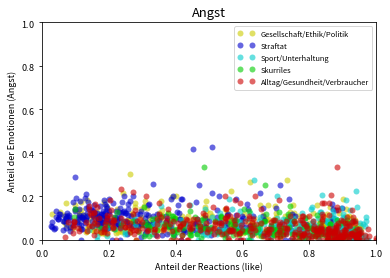

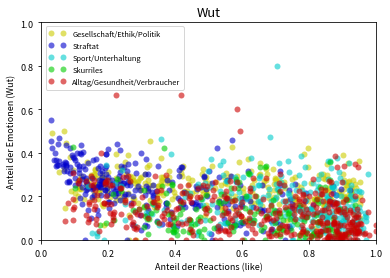

In [22]:
# scatter plots to compare fraction of reactions and emotions and see if they match
reaction = "like"
colorlist = get_colors(len(categories))
colordict = {cat: (colorlist[i][0], colorlist[i][1], colorlist[i][2]) for i, cat in enumerate(sorted(categories))}
for emo in ["Freude", "Trauer", "Angst", "Wut"]:
    plt.figure()
    for post_cat in categories:
        reactions = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
        emos = []
        for pid in post_categories:
            if post_categories[pid] == post_cat:
                r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
                reactions["like"].append(post_likes[pid]/r_total)
                reactions["love"].append(post_love[pid]/r_total)
                reactions["sad"].append(post_sad[pid]/r_total)
                reactions["haha"].append(post_haha[pid]/r_total)
                reactions["angry"].append(post_angry[pid]/r_total)
                reactions["wow"].append(post_wow[pid]/r_total)
                r_total = len(emo_main_label_pred[pid])
                emos.append(sum([1 for i in emo_main_label_pred[pid] if emo_main_label_pred[pid][i] == emo])/r_total)
        plt.plot(reactions[reaction], emos, 'o', label=post_cat, color=colordict[post_cat], alpha=0.6, markeredgewidth=0)
    plt.xlabel("Anteil der Reactions (%s)" % reaction)
    plt.ylabel("Anteil der Emotionen (%s)" % emo)
    plt.title(emo)
    plt.xlim([0,1]);
    plt.ylim([0,1]);
    plt.legend(loc=0)
    plt.savefig("scatter_%s_%s.png" % (reaction, emo), dpi=300, bbox_inches="tight")

#### distribution of reactions

Gesellschaft/Ethik/Politik
                               like:  0.51 +/-  0.28    0.5
                              angry:  0.23 +/-  0.25    0.1
                                sad:  0.08 +/-  0.15    0.0
                               haha:  0.13 +/-  0.15    0.1
                                wow:  0.02 +/-  0.03    0.0
                               love:  0.02 +/-  0.03    0.0
Straftat
                               like:  0.34 +/-  0.23    0.3
                              angry:  0.42 +/-  0.29    0.5
                                sad:  0.13 +/-  0.16    0.1
                               haha:  0.07 +/-  0.12    0.0
                                wow:  0.04 +/-  0.05    0.0
                               love:  0.00 +/-  0.01    0.0
Sport/Unterhaltung
                               like:  0.73 +/-  0.20    0.8
                              angry:  0.03 +/-  0.07    0.0
                                sad:  0.06 +/-  0.16    0.0
                               haha:  0.13 +/

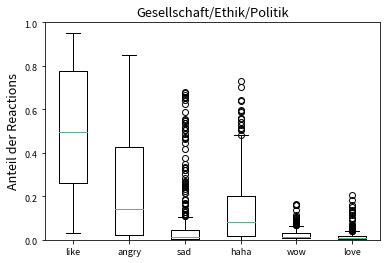

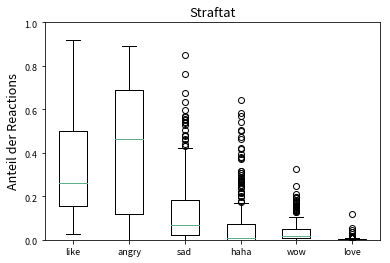

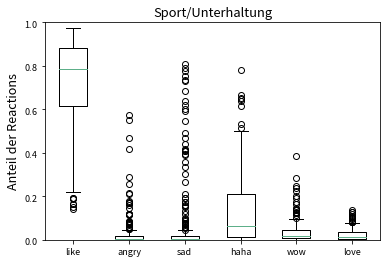

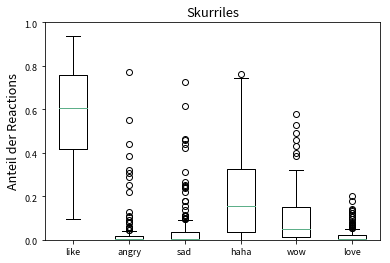

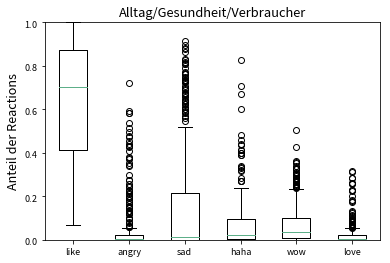

In [75]:
# reactions based on post category
reactions = {}
for post_cat in categories:
    reactions[post_cat] = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
            reactions[post_cat]["like"].append(post_likes[pid]/r_total)
            reactions[post_cat]["love"].append(post_love[pid]/r_total)
            reactions[post_cat]["sad"].append(post_sad[pid]/r_total)
            reactions[post_cat]["haha"].append(post_haha[pid]/r_total)
            reactions[post_cat]["angry"].append(post_angry[pid]/r_total)
            reactions[post_cat]["wow"].append(post_wow[pid]/r_total)
    r_labels = ["like", "angry", "sad", "haha", "wow", "love"]
    reactions_list = [reactions[post_cat][r] for r in r_labels]
    plt.figure()
    plt.boxplot(reactions_list, labels=r_labels)
    plt.ylabel("Anteil der Reactions", fontsize=14)
    plt.title(post_cat)
    plt.ylim([0,1]);
    plt.savefig("reaction_cat_%s.png" % post_cat[:4], dpi=300, bbox_inches="tight")
    print(post_cat)
    for i, r in enumerate(r_labels):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

like
         Gesellschaft/Ethik/Politik:  0.51 +/-  0.28    0.5
                           Straftat:  0.34 +/-  0.23    0.3
                 Sport/Unterhaltung:  0.73 +/-  0.20    0.8
                          Skurriles:  0.59 +/-  0.20    0.6
      Alltag/Gesundheit/Verbraucher:  0.63 +/-  0.27    0.7
love
         Gesellschaft/Ethik/Politik:  0.02 +/-  0.03    0.0
                           Straftat:  0.00 +/-  0.01    0.0
                 Sport/Unterhaltung:  0.02 +/-  0.03    0.0
                          Skurriles:  0.02 +/-  0.04    0.0
      Alltag/Gesundheit/Verbraucher:  0.02 +/-  0.05    0.0
sad
         Gesellschaft/Ethik/Politik:  0.08 +/-  0.15    0.0
                           Straftat:  0.13 +/-  0.16    0.1
                 Sport/Unterhaltung:  0.06 +/-  0.16    0.0
                          Skurriles:  0.05 +/-  0.11    0.0
      Alltag/Gesundheit/Verbraucher:  0.16 +/-  0.25    0.0
haha
         Gesellschaft/Ethik/Politik:  0.13 +/-  0.15    0.1
                     

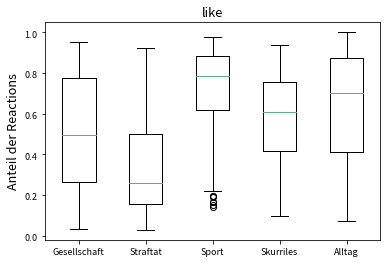

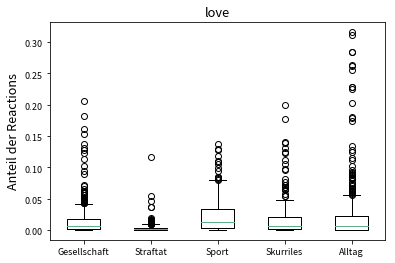

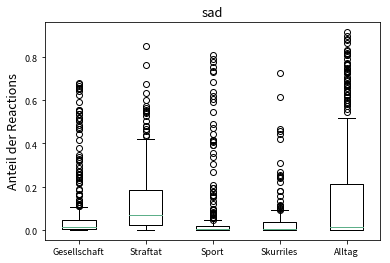

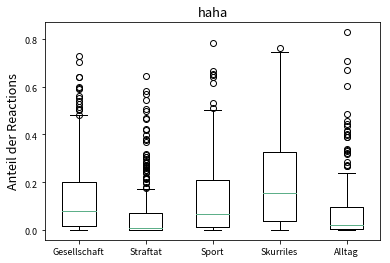

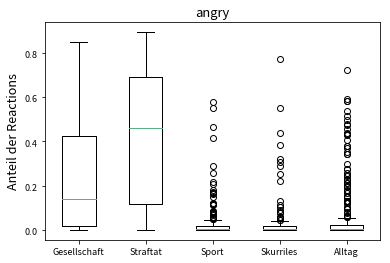

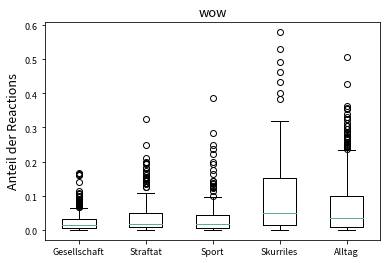

In [76]:
# reactions based on post category (from emo words)
reactions_inv = invert_dict2(reactions)
for react in reactions_inv:
    reactions_list = [reactions_inv[react][r] for r in categories]
    plt.figure()
    plt.boxplot(reactions_list, labels=[c.split("/")[0] for c in categories])
    plt.ylabel("Anteil der Reactions", fontsize=14)
    plt.title(react)
    plt.savefig("reactions_cat_%s.png" % react, dpi=300, bbox_inches="tight")
    print(react)
    for i, r in enumerate(categories):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

Merkel
                               like:  0.38 +/-  0.27    0.3
                              angry:  0.42 +/-  0.29    0.6
                                sad:  0.03 +/-  0.05    0.0
                               haha:  0.14 +/-  0.12    0.1
                                wow:  0.01 +/-  0.01    0.0
                               love:  0.01 +/-  0.01    0.0
Trump
                               like:  0.57 +/-  0.15    0.6
                              angry:  0.10 +/-  0.14    0.0
                                sad:  0.01 +/-  0.01    0.0
                               haha:  0.28 +/-  0.09    0.3
                                wow:  0.03 +/-  0.01    0.0
                               love:  0.02 +/-  0.02    0.0
Schicksal
                               like:  0.36 +/-  0.21    0.3
                              angry:  0.05 +/-  0.11    0.0
                                sad:  0.45 +/-  0.27    0.5
                               haha:  0.02 +/-  0.07    0.0
                 

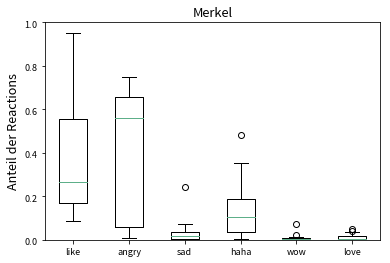

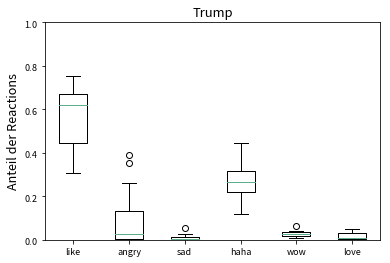

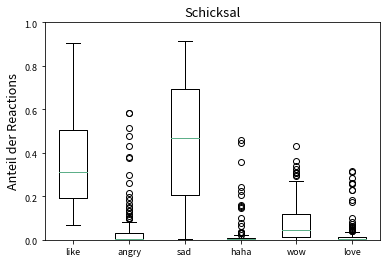

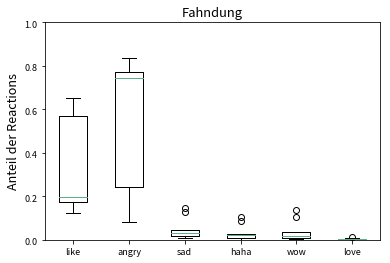

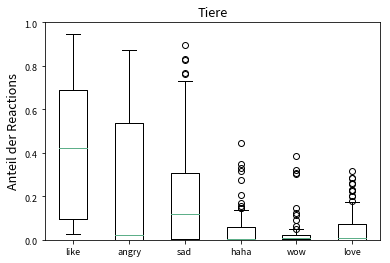

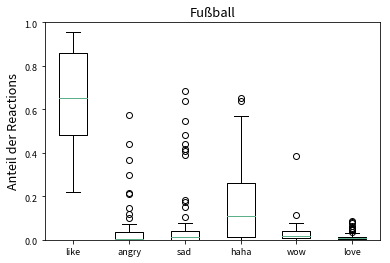

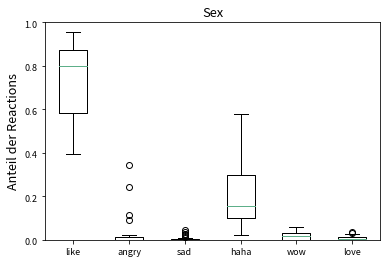

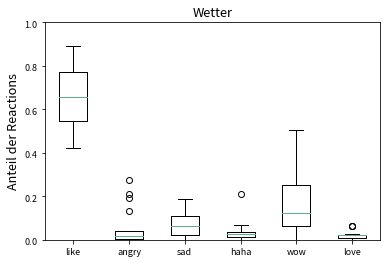

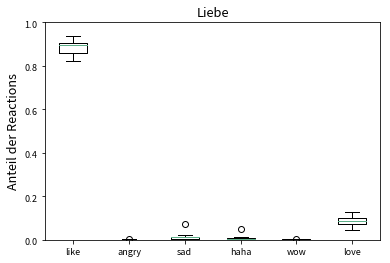

In [77]:
# reactions based on post subcategory
reactions = {}
for post_cat in subcategories:
    reactions[post_cat] = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
    for pid in post_subcategories:
        if post_cat in post_subcategories[pid]:
            r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
            reactions[post_cat]["like"].append(post_likes[pid]/r_total)
            reactions[post_cat]["love"].append(post_love[pid]/r_total)
            reactions[post_cat]["sad"].append(post_sad[pid]/r_total)
            reactions[post_cat]["haha"].append(post_haha[pid]/r_total)
            reactions[post_cat]["angry"].append(post_angry[pid]/r_total)
            reactions[post_cat]["wow"].append(post_wow[pid]/r_total)
    r_labels = ["like", "angry", "sad", "haha", "wow", "love"]
    reactions_list = [reactions[post_cat][r] for r in r_labels]
    plt.figure()
    plt.boxplot(reactions_list, labels=r_labels)
    plt.ylabel("Anteil der Reactions", fontsize=14)
    plt.title(post_cat)
    plt.ylim([0,1]);
    plt.savefig("reaction_subcat_%s.png" % post_cat[:4], dpi=300, bbox_inches="tight")
    print(post_cat)
    for i, r in enumerate(r_labels):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

like
                             Merkel:  0.38 +/-  0.27    0.3
                              Trump:  0.57 +/-  0.15    0.6
                          Schicksal:  0.36 +/-  0.21    0.3
                           Fahndung:  0.34 +/-  0.21    0.2
                              Tiere:  0.41 +/-  0.30    0.4
                            Fußball:  0.65 +/-  0.21    0.7
                                Sex:  0.75 +/-  0.16    0.8
                             Wetter:  0.65 +/-  0.15    0.7
                              Liebe:  0.89 +/-  0.03    0.9
love
                             Merkel:  0.01 +/-  0.01    0.0
                              Trump:  0.02 +/-  0.02    0.0
                          Schicksal:  0.03 +/-  0.07    0.0
                           Fahndung:  0.00 +/-  0.00    0.0
                              Tiere:  0.06 +/-  0.09    0.0
                            Fußball:  0.02 +/-  0.02    0.0
                                Sex:  0.01 +/-  0.01    0.0
                             W

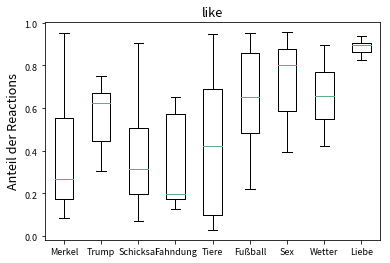

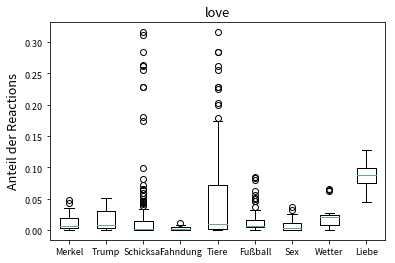

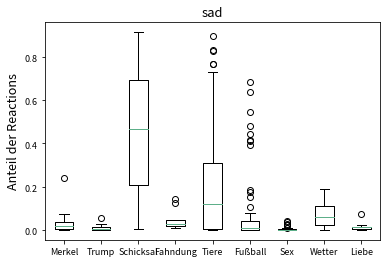

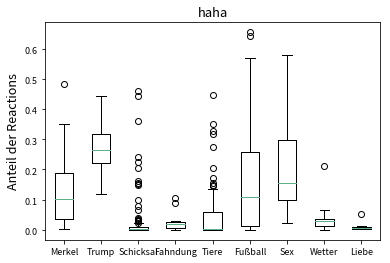

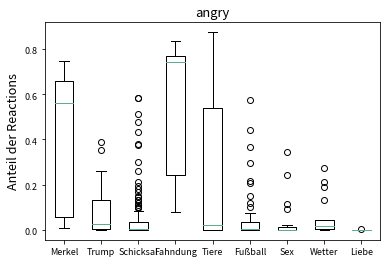

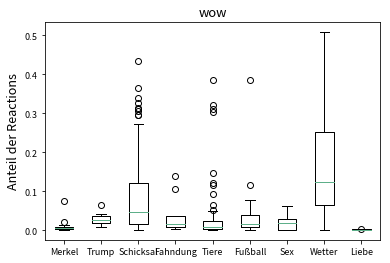

In [78]:
# reactions based on post category (from emo words)
reactions_inv = invert_dict2(reactions)
for react in reactions_inv:
    reactions_list = [reactions_inv[react][r] for r in subcategories]
    plt.figure()
    plt.boxplot(reactions_list, labels=[c.split("/")[0] for c in subcategories])
    plt.ylabel("Anteil der Reactions", fontsize=14)
    plt.title(react)
    plt.savefig("reactions_subcat_%s.png" % react, dpi=300, bbox_inches="tight")
    print(react)
    for i, r in enumerate(subcategories):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

Gesellschaft/Ethik/Politik
                                Wut:  0.18 +/-  0.06    0.2
                             Trauer:  0.05 +/-  0.03    0.0
                              Angst:  0.04 +/-  0.04    0.0
                             Freude:  0.27 +/-  0.08    0.3
                                  -:  0.46 +/-  0.08    0.5
Straftat
                                Wut:  0.19 +/-  0.09    0.2
                             Trauer:  0.06 +/-  0.05    0.1
                              Angst:  0.05 +/-  0.04    0.0
                             Freude:  0.22 +/-  0.10    0.2
                                  -:  0.48 +/-  0.09    0.5
Sport/Unterhaltung
                                Wut:  0.11 +/-  0.07    0.1
                             Trauer:  0.05 +/-  0.06    0.0
                              Angst:  0.02 +/-  0.03    0.0
                             Freude:  0.32 +/-  0.11    0.3
                                  -:  0.49 +/-  0.11    0.5
Skurriles
                                Wut

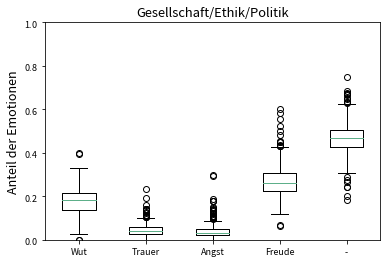

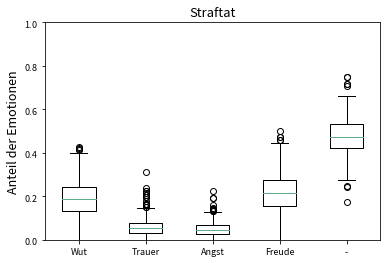

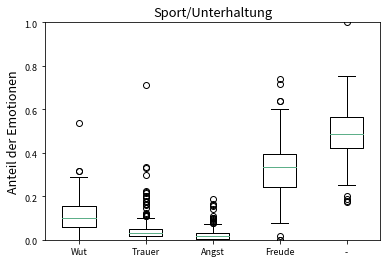

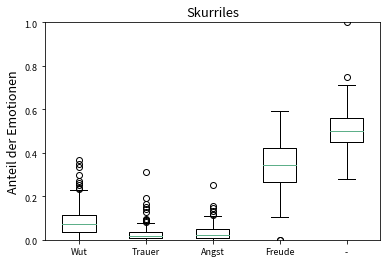

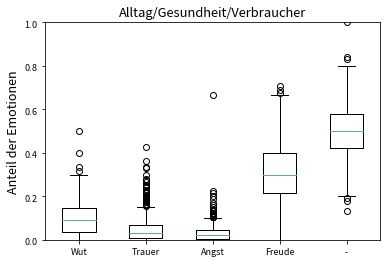

In [70]:
# emotions based on post category (from emo words)
emotions = ["Wut", "Trauer", "Angst", "Freude", "-"]
reactions = {}
for post_cat in categories:
    reactions[post_cat] = {e: [] for e in emotions}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[post_cat][emo].append(sum([1 for i in emo_main_label[pid] if emo_main_label[pid][i] == emo])/r_total)
    reactions_list = [reactions[post_cat][r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions_list, labels=emotions)
    plt.ylabel("Anteil der Emotionen", fontsize=14)
    plt.title(post_cat)
    plt.ylim([0,1]);
    plt.savefig("emotions_cat_%s.png" % post_cat[:4], dpi=300, bbox_inches="tight")
    print(post_cat)
    for i, r in enumerate(emotions):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

Wut
         Gesellschaft/Ethik/Politik:  0.18 +/-  0.06    0.2
                           Straftat:  0.19 +/-  0.09    0.2
                 Sport/Unterhaltung:  0.11 +/-  0.07    0.1
                          Skurriles:  0.09 +/-  0.07    0.1
      Alltag/Gesundheit/Verbraucher:  0.10 +/-  0.08    0.1
Trauer
         Gesellschaft/Ethik/Politik:  0.05 +/-  0.03    0.0
                           Straftat:  0.06 +/-  0.05    0.1
                 Sport/Unterhaltung:  0.05 +/-  0.06    0.0
                          Skurriles:  0.03 +/-  0.04    0.0
      Alltag/Gesundheit/Verbraucher:  0.06 +/-  0.07    0.0
Angst
         Gesellschaft/Ethik/Politik:  0.04 +/-  0.04    0.0
                           Straftat:  0.05 +/-  0.04    0.0
                 Sport/Unterhaltung:  0.02 +/-  0.03    0.0
                          Skurriles:  0.03 +/-  0.04    0.0
      Alltag/Gesundheit/Verbraucher:  0.03 +/-  0.05    0.0
Freude
         Gesellschaft/Ethik/Politik:  0.27 +/-  0.08    0.3
                

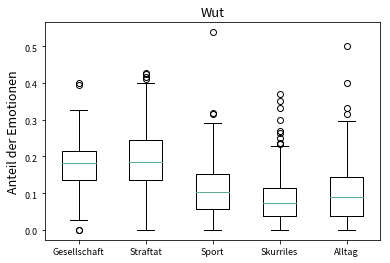

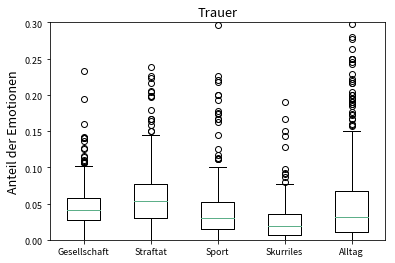

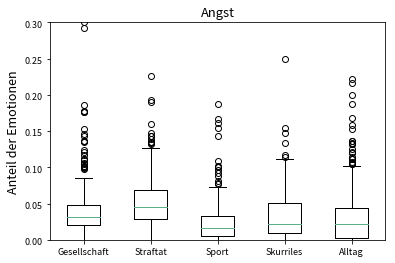

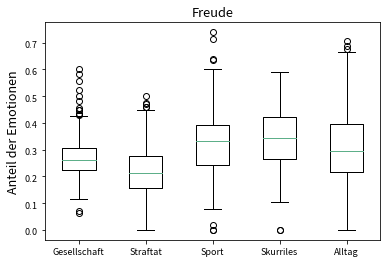

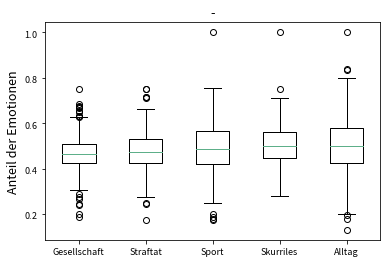

In [72]:
# emotions based on post category (from emo words)
reactions_inv = invert_dict2(reactions)
for emo in emotions:
    reactions_list = [reactions_inv[emo][r] for r in categories]
    plt.figure()
    plt.boxplot(reactions_list, labels=[c.split("/")[0] for c in categories])
    plt.ylabel("Anteil der Emotionen", fontsize=14)
    plt.title(emo)
    if emo in ["Trauer", "Angst"]:
        plt.ylim([0,0.3])
    plt.savefig("emotions_cat_%s.png" % emo, dpi=300, bbox_inches="tight")
    print(emo)
    for i, r in enumerate(categories):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

Gesellschaft/Ethik/Politik
                                Wut:  0.23 +/-  0.08    0.2
                             Trauer:  0.10 +/-  0.06    0.1
                              Angst:  0.08 +/-  0.04    0.1
                             Freude:  0.20 +/-  0.08    0.2
                                  -:  0.38 +/-  0.08    0.4
Straftat
                                Wut:  0.24 +/-  0.10    0.2
                             Trauer:  0.12 +/-  0.08    0.1
                              Angst:  0.10 +/-  0.06    0.1
                             Freude:  0.17 +/-  0.10    0.2
                                  -:  0.37 +/-  0.09    0.4
Sport/Unterhaltung
                                Wut:  0.16 +/-  0.10    0.1
                             Trauer:  0.09 +/-  0.10    0.1
                              Angst:  0.06 +/-  0.04    0.0
                             Freude:  0.31 +/-  0.12    0.3
                                  -:  0.38 +/-  0.11    0.4
Skurriles
                                Wut

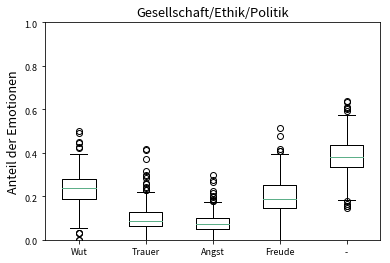

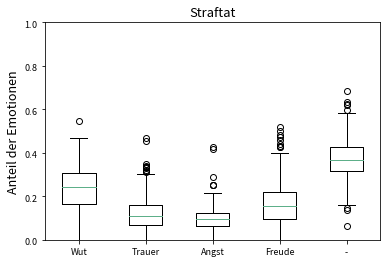

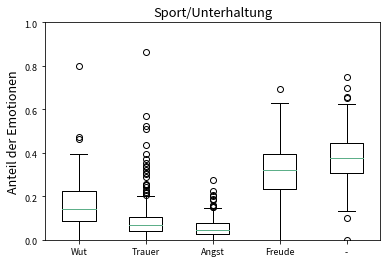

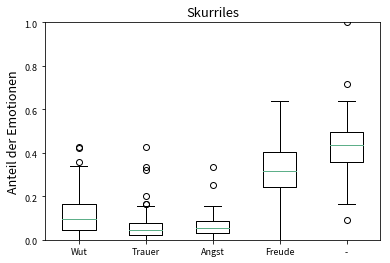

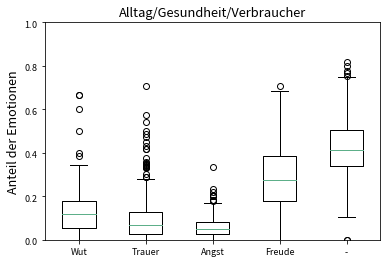

In [56]:
# emotions based on post category (from word vectors)
emotions = ["Wut", "Trauer", "Angst", "Freude", "-"]
for post_cat in categories:
    reactions = {e: [] for e in emotions}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[emo].append(sum([1 for i in emo_main_label_pred[pid] if emo_main_label_pred[pid][i] == emo])/r_total)
    reactions = [reactions[r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions, labels=emotions)
    plt.ylabel("Anteil der Emotionen", fontsize=14)
    plt.title(post_cat)
    plt.ylim([0,1]);
    plt.savefig("emotions_pred_cat_%s.png" % post_cat[:4], dpi=300, bbox_inches="tight")
    print(post_cat)
    for i, r in enumerate(emotions):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions[i]), np.std(reactions[i]), np.median(reactions[i])))

Merkel
                                Wut:  0.20 +/-  0.05    0.2
                             Trauer:  0.05 +/-  0.02    0.1
                              Angst:  0.03 +/-  0.01    0.0
                             Freude:  0.24 +/-  0.05    0.2
                                  -:  0.47 +/-  0.06    0.5
Trump
                                Wut:  0.17 +/-  0.06    0.1
                             Trauer:  0.04 +/-  0.04    0.0
                              Angst:  0.05 +/-  0.08    0.0
                             Freude:  0.28 +/-  0.06    0.3
                                  -:  0.47 +/-  0.06    0.5
Schicksal
                                Wut:  0.14 +/-  0.09    0.1
                             Trauer:  0.12 +/-  0.10    0.1
                              Angst:  0.05 +/-  0.04    0.0
                             Freude:  0.22 +/-  0.12    0.2
                                  -:  0.47 +/-  0.13    0.5
Fahndung
                                Wut:  0.17 +/-  0.04    0.2
        

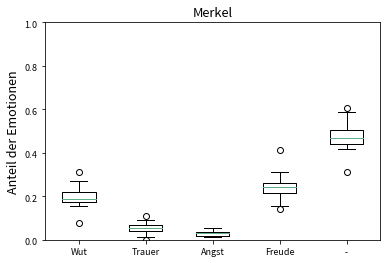

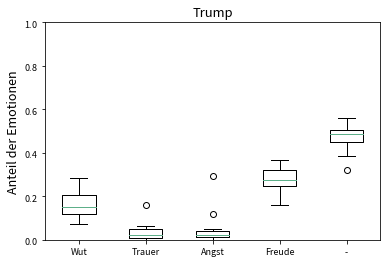

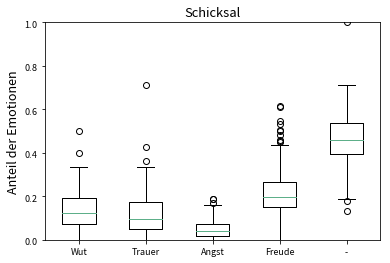

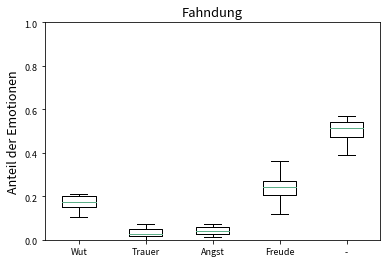

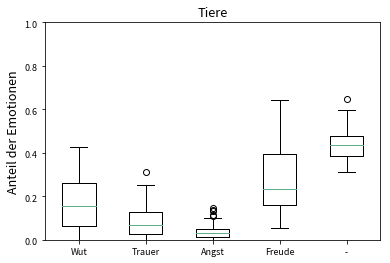

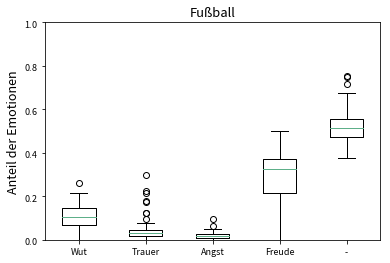

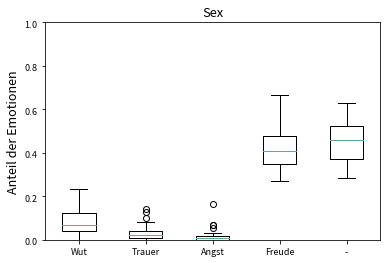

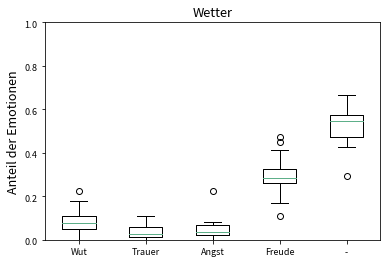

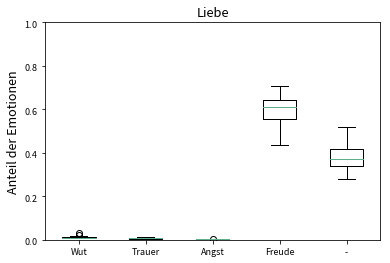

In [67]:
# emotions based on post subcategory (from emo words)
emotions = ["Wut", "Trauer", "Angst", "Freude", "-"]
reactions = {}
for post_cat in subcategories:
    reactions[post_cat] = {e: [] for e in emotions}
    for pid in post_subcategories:
        if post_cat in post_subcategories[pid]:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[post_cat][emo].append(sum([1 for i in emo_main_label[pid] if emo_main_label[pid][i] == emo])/r_total)
    reactions_list = [reactions[post_cat][r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions_list, labels=emotions)
    plt.ylabel("Anteil der Emotionen", fontsize=14)
    plt.title(post_cat)
    plt.ylim([0,1]);
    plt.savefig("emotions_subcat_%s.png" % post_cat, dpi=300, bbox_inches="tight")
    print(post_cat)
    for i, r in enumerate(emotions):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

Wut
                             Merkel:  0.20 +/-  0.05    0.2
                              Trump:  0.17 +/-  0.06    0.1
                          Schicksal:  0.14 +/-  0.09    0.1
                           Fahndung:  0.17 +/-  0.04    0.2
                              Tiere:  0.17 +/-  0.12    0.2
                            Fußball:  0.11 +/-  0.06    0.1
                                Sex:  0.08 +/-  0.06    0.1
                             Wetter:  0.09 +/-  0.06    0.1
                              Liebe:  0.01 +/-  0.01    0.0
Trauer
                             Merkel:  0.05 +/-  0.02    0.1
                              Trump:  0.04 +/-  0.04    0.0
                          Schicksal:  0.12 +/-  0.10    0.1
                           Fahndung:  0.03 +/-  0.02    0.0
                              Tiere:  0.08 +/-  0.07    0.1
                            Fußball:  0.05 +/-  0.06    0.0
                                Sex:  0.03 +/-  0.03    0.0
                             

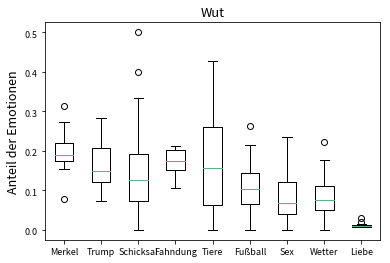

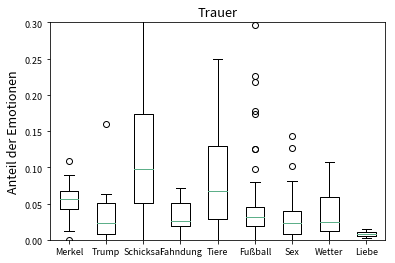

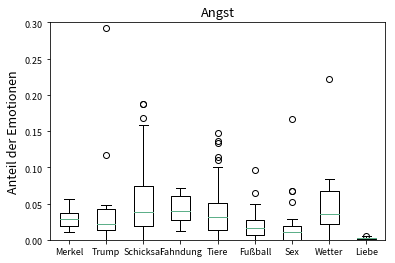

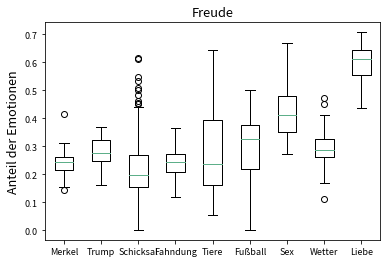

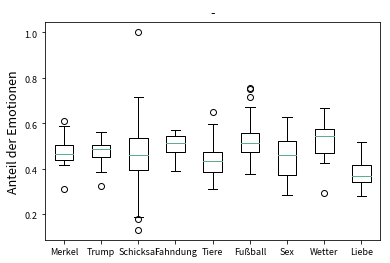

In [68]:
# emotions based on post category (from emo words)
reactions_inv = invert_dict2(reactions)
for emo in emotions:
    reactions_list = [reactions_inv[emo][r] for r in subcategories]
    plt.figure()
    plt.boxplot(reactions_list, labels=subcategories)
    plt.ylabel("Anteil der Emotionen", fontsize=14)
    plt.title(emo)
    if emo in ["Trauer", "Angst"]:
        plt.ylim([0,0.3])
    plt.savefig("emotions_subcat_%s.png" % emo, dpi=300, bbox_inches="tight")
    print(emo)
    for i, r in enumerate(subcategories):
        print("%35s: %5.2f +/- %5.2f   %4.1f" % (r, np.mean(reactions_list[i]), np.std(reactions_list[i]), np.median(reactions_list[i])))

## Save collected Post stats in CSV file

In [24]:
# (some of the) original fields of the post file with additional categories
cs_columns = ["post_id", "post_text", "category", "subcategory", "react_likes", "react_love", "react_haha", "react_sad", "react_wow",
              "react_angry", "number of comments", "positive sent", "negative sent", "neutral sent", "Wut", "Angst",
              "Trauer", "Freude", "neutral", "avg words in comments", "median words in comments"]
index = sorted(posts.keys())
collected_stats = {}
collected_stats["post_id"] = index
collected_stats["post_text"] = [posts[i] for i in index]
collected_stats["category"] = [post_categories[i] for i in index]
collected_stats["subcategory"] = [post_subcategories[i] if i in post_subcategories else "" for i in index]
collected_stats["react_likes"] = [post_likes[i] for i in index]
collected_stats["react_love"] = [post_love[i] for i in index]
collected_stats["react_haha"] = [post_haha[i] for i in index]
collected_stats["react_sad"] = [post_sad[i] for i in index]
collected_stats["react_wow"] = [post_wow[i] for i in index]
collected_stats["react_angry"] = [post_angry[i] for i in index]
collected_stats["number of comments"] = [len(comments[i]) for i in index]
collected_stats["avg words in comments"] = [np.mean(list(number_of_words[i].values())) for i in index]
collected_stats["median words in comments"] = [np.median(list(number_of_words[i].values())) for i in index]
collected_stats["positive sent"] = [100*len([1 for s in sent_scores[i].values() if s > 0])/len(sent_scores[i]) for i in index]
collected_stats["negative sent"] = [100*len([1 for s in sent_scores[i].values() if s < 0])/len(sent_scores[i]) for i in index]
collected_stats["neutral sent"] = [100*len([1 for s in sent_scores[i].values() if s == 0])/len(sent_scores[i]) for i in index]
collected_stats["Wut"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Wut"])/len(emo_main_label[i]) for i in index]
collected_stats["Angst"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Angst"])/len(emo_main_label[i]) for i in index]
collected_stats["Trauer"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Trauer"])/len(emo_main_label[i]) for i in index]
collected_stats["Freude"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Freude"])/len(emo_main_label[i]) for i in index]
collected_stats["neutral"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "-"])/len(emo_main_label[i]) for i in index]
df = pd.DataFrame(collected_stats, columns=cs_columns)
df.to_csv("collected_stats.csv", index=False)

### word frequencies

In [100]:
# most frequent emotion words
all_emos = emo_Wut | emo_Angst | emo_Freude | emo_Trauer | emojis_Freude | emojis_Trauer | emojis_Wut | emojis_Angst
all_text = []
for pid in comments_pp:
    for c in comments_pp[pid]:
        all_text.extend([w for w in comments_pp[pid][c] if w in all_emos])
word_counts = Counter(all_text)
for word in sorted(all_emos, key=lambda x: word_counts[x], reverse=True):
    print("%20s: %10i" % (word, word_counts[word]))

                   😂:     125039
               schon:      27130
                   😍:      19136
                   ❤:      17636
                   🤣:      16712
             einfach:      11966
                 gut:      11223
                   😘:      10901
                   😡:       8737
                   😉:       8482
                   👍:       8324
             richtig:       7747
                   😅:       6970
                   😁:       6334
              leider:       4893
              stimmt:       3839
                   😱:       3760
                   😊:       3758
               liebe:       3641
                   😠:       3325
              mutter:       3261
                haha:       3210
                   😎:       3188
             traurig:       3173
                   😄:       2862
                   😢:       2735
                   👌:       2664
                   😀:       2568
                   😜:       2552
                   😳:       2193
          

        befriedigung:         16
            beliebig:         16
              faseln:         16
             zittern:         16
       schnappatmung:         16
           grosskotz:         16
           kleinlich:         16
         erscheinung:         16
    schmierentheater:         16
              racker:         16
                balz:         16
             glotzen:         16
          schlagerei:         16
           verflucht:         16
      diskreditieren:         16
           todesfall:         16
          schatzchen:         16
              ficker:         16
        schikanieren:         16
         unerwunscht:         16
           schropfen:         16
          psychopath:         16
              schrei:         16
             notlage:         15
              knecht:         15
            unlustig:         15
              schund:         15
              lumpen:         15
         beschonigen:         15
             gestank:         15
        er

        verschachern:          2
          deprimiert:          2
          vergratzen:          2
           greenhorn:          2
        enthusiasmus:          2
          kasperkopf:          2
            einerlei:          2
              ramsch:          2
           desperado:          2
             vorlaut:          2
        verarscherei:          2
              hohnen:          2
             ovation:          2
            monstrum:          2
              barbar:          2
            hallodri:          2
          hanebuchen:          2
             drohend:          2
       schweinebande:          2
         hergebracht:          2
         psychotisch:          2
          antichrist:          2
                fete:          2
           ergaunern:          2
          strunzdoof:          2
                kess:          2
         dezimierung:          2
             knurren:          2
            impulsiv:          2
             gejohle:          2
          

  untergangsstimmung:          0
        jammerschade:          0
      dickkopfigkeit:          0
         schmalerung:          0
             gnatzig:          0
   schreckhaftigkeit:          0
           hohlfigur:          0
         schweinisch:          0
         hinwegrasen:          0
            schranze:          0
       knickerigkeit:          0
        verschnarcht:          0
 unerfreulicherweise:          0
         absprechend:          0
        muffensausen:          0
       transusigkeit:          0
           degoutant:          0
              lumpig:          0
         herumhangen:          0
          bedroppelt:          0
    herumspekulieren:          0
 schreckensbotschaft:          0
          jammervoll:          0
         depperltest:          0
            plagerei:          0
        unwillkommen:          0
            murrisch:          0
  stammtischweisheit:          0
          frappieren:          0
         zwistigkeit:          0
    idioti

       gehirninfarkt:          0
          volllabern:          0
     starrkopfigkeit:          0
           vernatzen:          0
      freudenschreie:          0
              cyanid:          0
             stieren:          0
         miesepetrig:          0
        phantasterei:          0
           redescheu:          0
         verscheiden:          0
        rumfaulenzen:          0
           exzitabel:          0
      niedergedruckt:          0
       erschrecklich:          0
     unbeschwertheit:          0
          doof doofe:          0
             festakt:          0
     scheusslichkeit:          0
              miefig:          0
      schlechtmachen:          0
            mickerig:          0
        beschonigung:          0
           erzittern:          0
             trubsal:          0
             brummig:          0
       hereinplatzen:          0
             hakelei:          0
             trashen:          0
         desillusion:          0
      geru

In [102]:
# most frequent other words in comments all together
all_text = []
for pid in comments_pp:
    for c in comments_pp[pid]:
        all_text.extend([w for w in comments_pp[pid][c] if not w in all_emos])
word_counts = Counter(all_text)
for word in sorted(word_counts, key=word_counts.get, reverse=True)[:2000]:
    print("%20s: %10i" % (word, word_counts[word]))

                 die:     169053
                 und:     141527
                 das:     126151
               nicht:     104966
                 ich:     101778
                 der:      95040
                 ist:      94792
                  es:      78309
                  in:      64907
                auch:      61707
                  zu:      57324
                  so:      52904
                 sie:      52219
                 man:      48742
                 was:      47931
                 mit:      46858
                 ein:      45864
                 den:      44822
                 fur:      41818
                aber:      39978
                sich:      37823
                  du:      37295
                 hat:      36746
                  ja:      36441
                 wie:      36070
                 mal:      35853
                 nur:      35355
                wenn:      34995
                  da:      33236
                 auf:      32948
          

                 cdu:        825
         tatsachlich:        824
                 nee:        819
              stelle:        819
             zukunft:        817
                  iv:        817
                ding:        816
           zumindest:        815
               getan:        815
              stellt:        814
            realitat:        814
                hirn:        813
                  se:        812
          sicherheit:        811
                mama:        809
               nennt:        809
            gefunden:        808
               klein:        803
                nina:        803
           gegenuber:        801
                   🙊:        800
                  eu:        800
         anscheinend:        799
                sinn:        798
           situation:        797
            stefanie:        794
              langer:        792
           katharina:        791
               fehlt:        790
          abschieben:        787
          

          zusatzlich:        309
              denkst:        309
               kalte:        309
                netz:        308
              schuss:        308
                bahn:        308
            patricia:        308
                   l:        308
               armer:        308
         rechtsstaat:        308
                amis:        308
                  my:        307
             spiegel:        307
            schlimme:        307
              zweite:        307
              drecks:        307
              franzi:        307
           flughafen:        307
              jurgen:        306
           gehandelt:        306
      aufmerksamkeit:        306
              rucken:        305
                 dat:        305
              meines:        305
              selben:        305
                   🖒:        305
         mitbekommen:        304
               polen:        304
            straftat:        304
                gebt:        303
          